## Import required libraries

In [15]:
import numpy as np
import scipy as scipy
from scipy.optimize import dual_annealing
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
# graph representation
import networkx as nx
import json
# animation
from IPython.display import HTML

# Notebook Intro

I wanted to try something for the optimization of the grid while looking for the best coverage at the same time. So my idea was to use a **heuristic method (Simulated Annealing)** to look around different possible grid layouts.

**NB**: I just wanted to try this idea, I am not sure it's the best option, and I am open to any comments!

### Here are the steps for the algorithm:
1. **Problem definition**: 
    - Define problem variables
    - Fix the number of grid points
    - Initialize the position of grid points randomly (*Certainly a clever guess to start would improve the algorithm*)

2. **Simulated Annealing**:
    - Look around different grid layouts

3. **Grid Evaluation**:
    - For each grid, it calls the cost function

4. **Cost Function Details**:
    - Represent the grid layout in a graph with weights for each vertex given by their population coverage
    - Find the *weighted MIS (Maximum Independent Set)* of the given grid using a greedy algorithm (*because classical algorithms are too long for my tests*)
    - Then calculate a cost function (*Here I did coverage + penalty, but I am pretty sure it could be improved*)

5. **Termination**:
    - The simulated annealing continues until it reaches its maximum number of iterations

### Next Steps:
Trying to first optimize this classical approach could help us really find optimal antenna placement. Then we could try to implement a *hybrid approach* to calculate the weighted MIS using **NAQC (Noisy Intermediate-Scale Quantum Computing)**.


## Define Problem Data

### Plot population points from Data

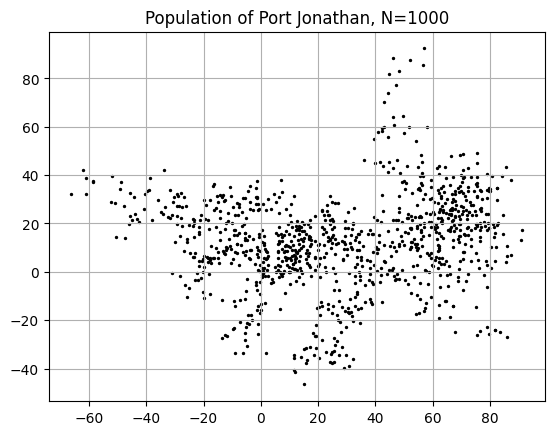

In [2]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[7]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.scatter(x, y, s=2, facecolor='black')
plt.title('Population of {}, N={}'.format(city_name, len(x)))
plt.grid(True)
plt.show()

### Prettier vizualization of population density

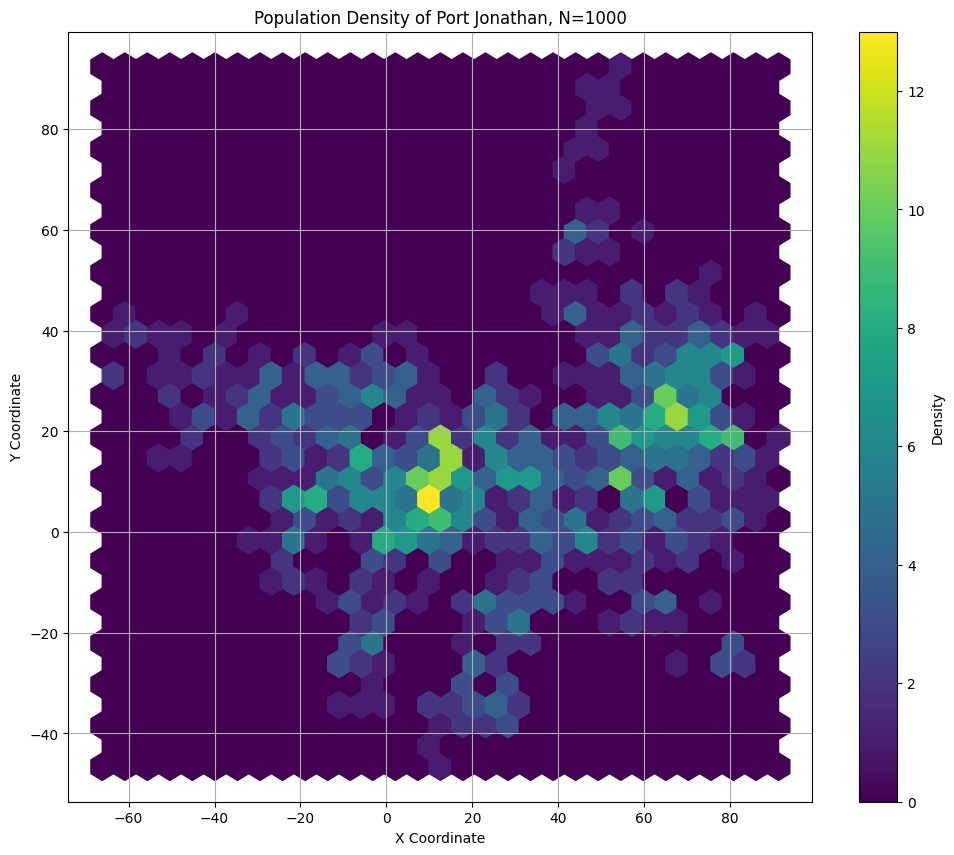

In [3]:
# Create hexbin plot
plt.figure(figsize=(12, 10))
plt.hexbin(x, y, gridsize=30, cmap='viridis')
#plt.hist2d(x, y, bins=30, cmap='viridis')
plt.colorbar(label='Density')

# Add titles and labels
plt.title('Population Density of {}, N={}'.format(city_name, len(x)))
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

### Define the Problem Parameter

In [4]:
# Problem Parameters
population_x = x # x coordinates of the population
population_y = y # y coordinates of the population
R_antennas = 25  # Operating radius for each antenna
max_antennas = 70  # Maximum number of antennas
minimum_coverage = 0.7 * len(population_x) # Minimum coverage of the population required

# Coverage function

Optimization Function $COV$ for $N$ antennas is given by:

$$
COV = \sum_{i \in N} d_R(i) - B \sum_{i,j \in A} \text{Interfere}(i, j)
$$

where:

$$
\text{Interfere}(i, j) = \begin{cases} 
1, & \text{if } ||\vec{r}_i - \vec{r}_j|| < 2R \\
0, & \text{otherwise}
\end{cases}
$$

with
- coverage radius $R$ = 25
- antenna position $\vec{r}_i$
- $d_R(i)$ the nb. of population points within radius R around $\vec{r}_i$
- interference for $d < 2R$
- maximum nb. of antennas = 70
- minimum coverage = 0.7 $\times$ #population


In [5]:
def evaluate_coverage_final(population_x, population_y, placement, R_dist):
    x = population_x
    y = population_y
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))])
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]])
        for j in range(len(placement)):
            coord_j = np.array([placement[j]])
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist:
                    cost += -B


        dist = scipy.spatial.distance.cdist(coord_i, coords)
        cov = np.sum(dist < R_dist)
        cost += cov

    if cost < 0:
        return -np.inf
    else:
        return cost

# Utils function

Take a given grid and return the corresponding weighted graph

In [6]:
def get_weighted_graph(grid_points, population_x, population_y, R_antennas):
    # evaluate coverage of each grid points
    z_coverage = np.zeros(len(grid_points))
    coords = np.array([[population_x[i], population_y[i]] for i in range(len(population_x))])
    for i in range(len(grid_points)):
        start = np.array(grid_points[i])
        dist = scipy.spatial.distance.cdist(np.array([start]), coords)
        truth_table = (dist <= R_antennas)
        cov = np.sum(truth_table)
        z_coverage[i] = cov
    # create graph
    graph = nx.Graph()
    edges = KDTree(grid_points).query_pairs(R_antennas*(2+1e-3))
    graph.add_edges_from(edges)
    nx.set_node_attributes(graph, values = {i:{'weight':z_coverage[i]} for i in range(len(z_coverage))})
    return graph

Greedy solution to find a MIS

In [7]:
def greedy_solution(graph):
    new_graph = graph.copy()
    nodes = []
    while len(new_graph) > 1:
        attrs = nx.get_node_attributes(new_graph,'weight')
        list_indices = list(attrs.keys())
        all_weights = list(nx.get_node_attributes(new_graph,'weight').values())
        index_to_remove = np.argmax(all_weights)
        if all_weights[index_to_remove] < 1.0:
            break
        nodes.append(list_indices[index_to_remove])
        nodes_to_remove = [list_indices[index_to_remove]]
        for ind in new_graph.neighbors(list_indices[index_to_remove]):
            nodes_to_remove.append(ind)

        new_graph.remove_nodes_from(nodes_to_remove)
        if len(new_graph) == 0:
            break

    return nodes

For each grid points that is proposed, we take its MIS return by the greedy algorithm and calculate the coverage of the MIS (I added penalty points, but I am nor sure if that's a good idea)

In [8]:
def evaluate_coverage(grid_points, population_x, population_y, R):
    graph = get_weighted_graph(grid_points, population_x, population_y, R)

    # Calculate the MIS using a greedy approach
    mis_nodes = greedy_solution(graph)
    coverage = 0
    penalty = 0
    for node in mis_nodes:
        dist_to_population = np.linalg.norm(grid_points[node] - np.array([population_x, population_y]).T, axis=1)
        coverage += np.sum(dist_to_population < R)
        if np.sum(dist_to_population < R) == 0:
            penalty += -1000  # Large penalty for points that don't cover any population

    final_score = coverage + penalty - 10*len(mis_nodes) # Penalize the number of antennas

    return final_score, mis_nodes

Cost function for the simmulated annealing

In [9]:
call_count = 0
# Cost function to optimize
def cost_function(positions, population_x, population_y, R, num_points):
    global call_count
    call_count += 1
    # Reshape positions array into (num_points, 2) format
    grid_points = positions.reshape((num_points, 2))

    # Evaluate the coverage of the current grid configuration
    coverage, mis_nodes = evaluate_coverage(grid_points, population_x, population_y, R)

    # Store the MIS nodes for the final solution
    global final_mis_nodes
    final_mis_nodes = mis_nodes
    
    # Return negative coverage as we want to maximize it
    return -coverage

Callback function to track the evolution of the algorithm

In [10]:
# Lists to store the evolution of positions and coverage during the optimization
iteration_positions = []
iteration_mis = []
iteration_coverage = []

# Callback function to store the evolution of coverage at each iteration
def callback(x, f, context):
    grid_points = x.reshape((num_points, 2))
    coverage = -f
    iteration_positions.append(grid_points)
    iteration_mis.append(grid_points[final_mis_nodes])
    iteration_coverage.append(coverage)

# Simulated Annealing Algorithm

In [11]:
# Initial grid configuration
num_points = 7
R_antennas = 25
# Generate initial (x, y) positions within the range of population data
initial_positions = np.column_stack((
    np.random.uniform(population_x.min(), population_x.max(), num_points),
    np.random.uniform(population_y.min(), population_y.max(), num_points)
))

# Flatten initial positions for the optimizer
initial_positions_flat = initial_positions.flatten()

# Run simulated annealing using `scipy.optimize.dual_annealing`
bounds=[(population_x.min(), population_x.max())] * num_points + [(population_y.min(), population_y.max())] * num_points
result = dual_annealing(
    cost_function,
    bounds=bounds,
    args=(population_x, population_y, R_antennas, num_points),
    callback=callback,
    maxiter=200,
    restart_temp_ratio=1e-100  # Set this close to 0 to disable restarts (default value is 2e-5)
)


Plot final result

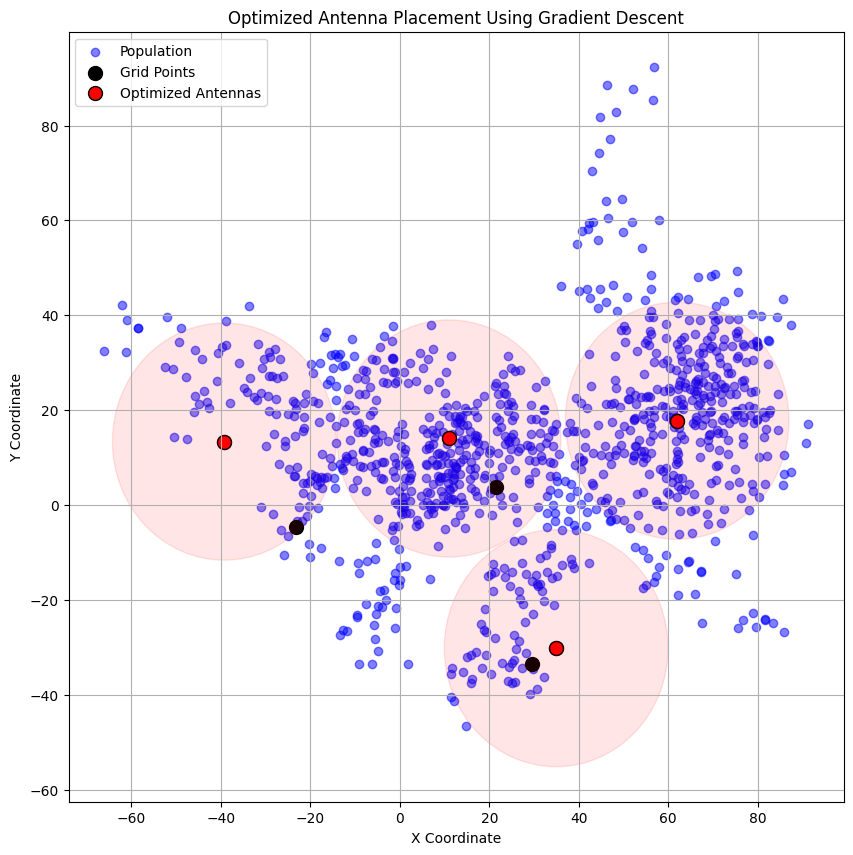

Final coverage: 818
Total number of calls to the cost function: 5976


In [12]:
# Reshape result to get optimized positions
optimized_positions = result.x.reshape((num_points, 2))
# Extract the positions of the MIS nodes
final_positions = optimized_positions[final_mis_nodes]

# Plot the optimized grid and population
plt.figure(figsize=(10, 10))
plt.scatter(population_x, population_y, c='blue', label='Population', alpha=0.5)
plt.scatter(optimized_positions[:, 0], optimized_positions[:, 1], c='black', label='Grid Points', s=100, edgecolors='black')
plt.scatter(final_positions[:, 0], final_positions[:, 1], c='red', label='Optimized Antennas', s=100, edgecolors='black')

for pos in final_positions:
    circle = plt.Circle((pos[0], pos[1]), R_antennas, color='red', alpha=0.1)
    plt.gca().add_patch(circle)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Optimized Antenna Placement Using Gradient Descent')
plt.legend()
plt.grid(True)
plt.show()

score = evaluate_coverage_final(population_x, population_y, final_positions, R_antennas)
print('Final coverage:', score)
print(f'Total number of calls to the cost function: {call_count}')

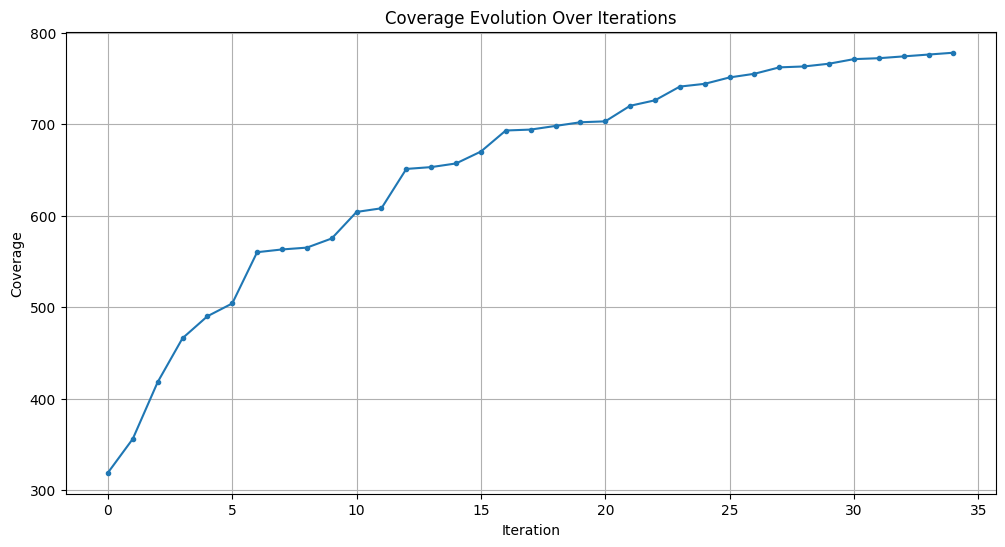

In [13]:
# Plot the evolution of the coverage over iterations
plt.figure(figsize=(12, 6))
plt.plot(range(len(iteration_coverage)), iteration_coverage, marker='.')
plt.xlabel('Iteration')
plt.ylabel('Coverage')
plt.title('Coverage Evolution Over Iterations')
plt.grid(True)
plt.show()

Animation for the evolution of antenna placement

In [16]:
from matplotlib.animation import FuncAnimation

# Plotting function for the animation
def update(frame):
    plt.clf()  # Clear the current figure to update the plot
    grid_points = iteration_positions[frame]
    coverage = iteration_coverage[frame]
    mis_positions = iteration_mis[frame]

    plt.scatter(population_x, population_y, c='blue', label='Population', alpha=0.5)
    plt.scatter(grid_points[:, 0], grid_points[:, 1], c='black', label='Grid Points', s=100, edgecolors='black')
    plt.scatter(mis_positions[:, 0], mis_positions[:, 1], c='red', label='Optimized Antennas', s=100, edgecolors='black')
    for pos in mis_positions:
        circle = plt.Circle((pos[0], pos[1]), R_antennas, color='red', alpha=0.1)
        plt.gca().add_patch(circle)
    plt.title(f"Iteration {frame + 1}, Coverage: {coverage:.4f}")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.legend()

# Params for animation
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

# Create the animation
anim = FuncAnimation(
    fig, update, frames=len(iteration_positions),
    interval=100, repeat=False
)

HTML(anim.to_jshtml())

/Users/macoco/Desktop/colin_ecole/colin_QC/neutral_atoms_quantum_computing/pulser/.venvPulser/lib/python3.10/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
